In [1]:
from torchvision import datasets as dt
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim

## Dataset

In [2]:
# load the training data
mnist = dt.MNIST('data', train=True, download=True)
mnist = list(mnist)[:2500]

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



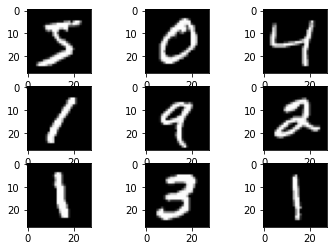

In [3]:
# plot the first 9 images in the training data
import matplotlib.pyplot as plt
for k, (image, label) in enumerate(mnist[:9]):
  plt.subplot(3, 3, k+1)
  plt.imshow(image, cmap='gray')

In [4]:
# transform the image data type to tensor
img_to_tensor = transforms.ToTensor()

In [5]:
# convert the last image we saw into a tensor
img_tensor = img_to_tensor(image)
img_tensor.shape

torch.Size([1, 28, 28])

In [6]:
# load the training data as tensor
mnist_train = dt.MNIST('data', train=True, transform=img_to_tensor)
mnist_train = list(mnist_train)[:2500]

In [7]:
#split data into training and validation
mnist_train, mnist_val = mnist_train[:2000], mnist_train[2000:]

## Linear Model in PyTorch

In [8]:
# assume 50 features, 1 linear output
simple_model = nn.Linear(50, 1)

In [9]:
weight, bias = list(simple_model.parameters())

In [10]:
# By default, PyTorch initializes these values to a random number close to 0
print(weight)
print(weight.shape)
print(bias)
print(bias.shape)

Parameter containing:
tensor([[ 0.0170,  0.1311, -0.0153,  0.0109, -0.0857,  0.1114, -0.0360,  0.0366,
         -0.0354, -0.0398, -0.0481,  0.0743,  0.0183, -0.0105, -0.0196,  0.0792,
          0.1287, -0.0025, -0.0239, -0.0683,  0.0574, -0.1062, -0.0557, -0.1304,
         -0.1021, -0.0292,  0.0138,  0.1365, -0.1031,  0.0741, -0.0053,  0.0527,
          0.0393, -0.0910, -0.0177, -0.1069,  0.1221, -0.1315, -0.0852, -0.0365,
         -0.0780, -0.0944,  0.0757, -0.1360,  0.0330,  0.1387,  0.0836, -0.0135,
         -0.0380, -0.0175]], requires_grad=True)
torch.Size([1, 50])
Parameter containing:
tensor([0.0684], requires_grad=True)
torch.Size([1])


<font color='red'>Like the example above, create the model to solve the MNIST digitclassification problem.</font>

In [11]:
############
# Your code
# Start
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))

print(model)
# End

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


## Prediction

In [12]:
def run_gradient_descent(model,batch_size=64,learning_rate=0.01,weight_decay=0,num_epochs=10):
  #define the best optimizer and loss function
  ############
  # Your code
  # Start
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
  # End

  
  iters, losses = [], []
  iters_sub, train_acc, val_acc = [], [] ,[]
  

  # PyTorch data loader
  train_loader = torch.utils.data.DataLoader(
      mnist_train,
      batch_size=batch_size, # batch size
      shuffle=True) # shuffle before each epoch


  # training
  for epoch in range(num_epochs):
    ############
    # Your code
    # Start
    running_loss = 0
    correct, total = 0, 0
    for images, labels in train_loader:
        # Flatten
        images = images.view(images.shape[0], -1)
        
        # training pass
        optimizer.zero_grad()
        output = model(images)

        loss = criterion(output, labels)
        
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        # calculate accuracy
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += int(labels.shape[0])

    else:
      val_acc_tmp = get_accuracy(model,mnist_val)
      val_acc.append(val_acc_tmp)
      print("Epoch {} - Training loss: {} - training accuracy: {} - validation accuracy: {}".format(epoch, running_loss/len(train_loader),correct / total,val_acc_tmp))
      losses.append(running_loss/len(train_loader))
      train_acc.append(correct / total)

    # End

  # plotting
  plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, learning_rate))
  plt.plot(losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, learning_rate))
  plt.plot(train_acc, label="Train")
  plt.plot(val_acc, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()

def get_accuracy(model, data):
  loader = torch.utils.data.DataLoader(data, batch_size=500)

  correct, total = 0, 0
  for xs, ts in loader:
      xs = xs.view(-1, 784) # flatten the image
      zs = model(xs)
      pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
      correct += pred.eq(ts.view_as(pred)).sum().item()
      total += int(ts.shape[0])
      return correct / total

Epoch 0 - Training loss: 2.3027472496032715 - training accuracy: 0.1015 - validation accuracy: 0.132
Epoch 1 - Training loss: 2.2823048681020737 - training accuracy: 0.2485 - validation accuracy: 0.35
Epoch 2 - Training loss: 2.252242587506771 - training accuracy: 0.4395 - validation accuracy: 0.562
Epoch 3 - Training loss: 2.2065130695700645 - training accuracy: 0.5875 - validation accuracy: 0.606
Epoch 4 - Training loss: 2.1342387720942497 - training accuracy: 0.602 - validation accuracy: 0.574
Epoch 5 - Training loss: 2.0072250589728355 - training accuracy: 0.567 - validation accuracy: 0.552
Epoch 6 - Training loss: 1.8066281005740166 - training accuracy: 0.5645 - validation accuracy: 0.54
Epoch 7 - Training loss: 1.5411705672740936 - training accuracy: 0.603 - validation accuracy: 0.64
Epoch 8 - Training loss: 1.2747339755296707 - training accuracy: 0.691 - validation accuracy: 0.7
Epoch 9 - Training loss: 1.0611965097486973 - training accuracy: 0.7535 - validation accuracy: 0.742


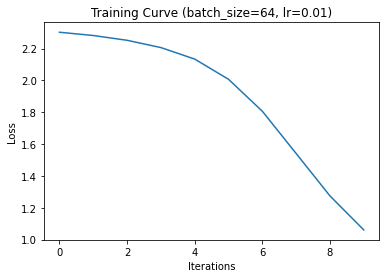

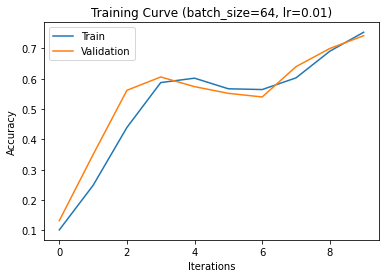

In [13]:
#model = ... #creat the model
run_gradient_descent(model, batch_size=64, learning_rate=0.01, num_epochs=10)